In [48]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, return_plot, plot_important_features
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Read in Data

In [49]:
%store -r correlative_factors
%store -r outlier_cols
correlative_factors.pop('saleprice', None)

# training data
house_train = pd.read_csv('../datasets/house_train_improved.csv')
# testing data
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# increase column width
pd.set_option('display.max_columns', 300)

In [50]:
house_train = house_train.query('gr_liv_area < 4000')

In [51]:
house_train.shape

(2049, 140)

In [52]:
drop = []

### Polytransformation

In [53]:
poly_columns = ['gr_liv_area', 'overall_qual_cond']   
def poly_features(df):
    for x in poly_columns:
        df[x+'_poly'] = df[x]**2
poly_features(house_train)
poly_features(house_test)

In [54]:
# add '_poly to poly_columns
poly_columns = [x+'_poly' for x in poly_columns]


### Log and Sqrt Transformations of Skewed Features

In [55]:
### Feature Transformation

sqrt_vars = ['total_bsmt_sf', 'house_age']
for col in sqrt_vars:
    house_train[col] = np.sqrt(house_train[col])
    house_test[col] = np.sqrt(house_test[col])

log_vars = ['lot_area', 'lot_frontage', 'gr_liv_area']
for col in log_vars:
    house_train[col] = np.log(house_train[col])
    house_test[col] = np.log(house_test[col])
    

In [56]:
log_vars

['lot_area', 'lot_frontage', 'gr_liv_area']

### Log Sale Price

In [57]:
house_train.saleprice = np.log(house_train.saleprice)
log_flag = True

In [58]:
correlative_factors = {k:v for k,v in correlative_factors.items() if v not in drop}

In [59]:
FEATURES = correlative_factors.keys()
FEATURES = [x for x in correlative_factors.keys() if x not in drop]
FEATURES+= poly_columns + outlier_cols

In [60]:

X = house_train[FEATURES]
y = house_train.saleprice
X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

### Instantiate LassoCV Model

In [61]:

mlr_lasso = LassoCV(alphas = np.arange(0.001, 10, 1))
#calculate residuals by creating predictions
mlr_lasso.fit(Xs_train,y_train)
preds = mlr_lasso.predict(Xs_train)
resid = y_train - preds

### Scores

In [62]:
def get_scores(model, standardize=True, log_price=False):
    
    if standardize == True:
        X_train_ = Xs_train
        X_val_ = Xs_val
    else:
        X_train_ = X_train
        X_val_ = X_val

    if log_price == True:
        var_preds = np.exp(preds)
        var_y_train = np.exp(y_train)
    else:
        var_preds = preds
        var_y_train = y_train

    scores_1 = (cross_val_score(model, X_train_, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=42)))
    print('Training R^2 Score: ', model.score(X_train_, y_train))
    print('Training RMSE: ', mean_squared_error(var_preds, var_y_train, squared = False))
    print('Cross Validation R^2 Score: ', scores_1.mean())
    print('Validation R^2 Score', model.score(X_val_, y_val))

get_scores(mlr_lasso, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9115836564361929
Training RMSE:  20786.29064479307
Cross Validation R^2 Score:  0.9004102597794879
Validation R^2 Score 0.905780992936511


### Plots

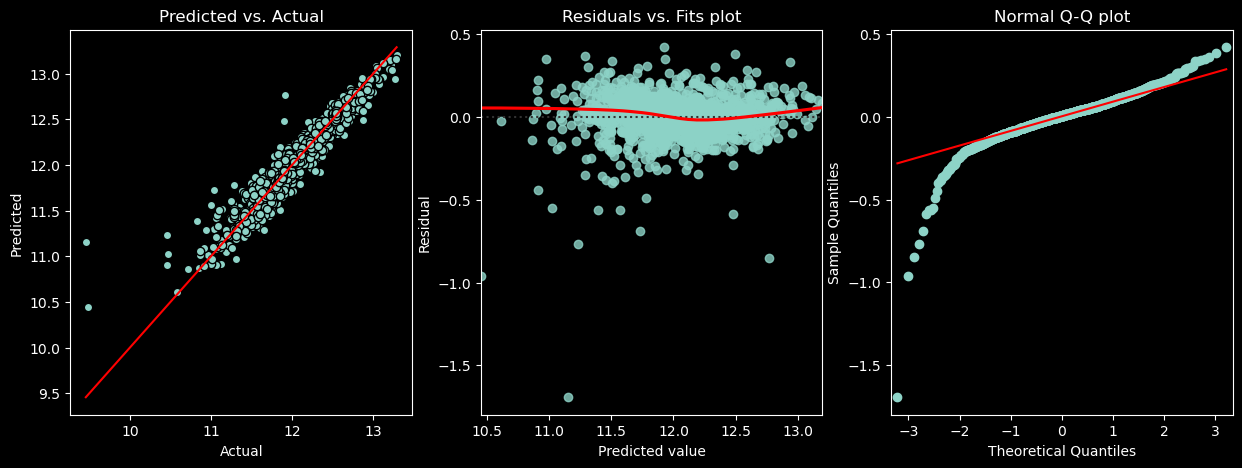

In [63]:
return_plot(preds, y_train, resid)

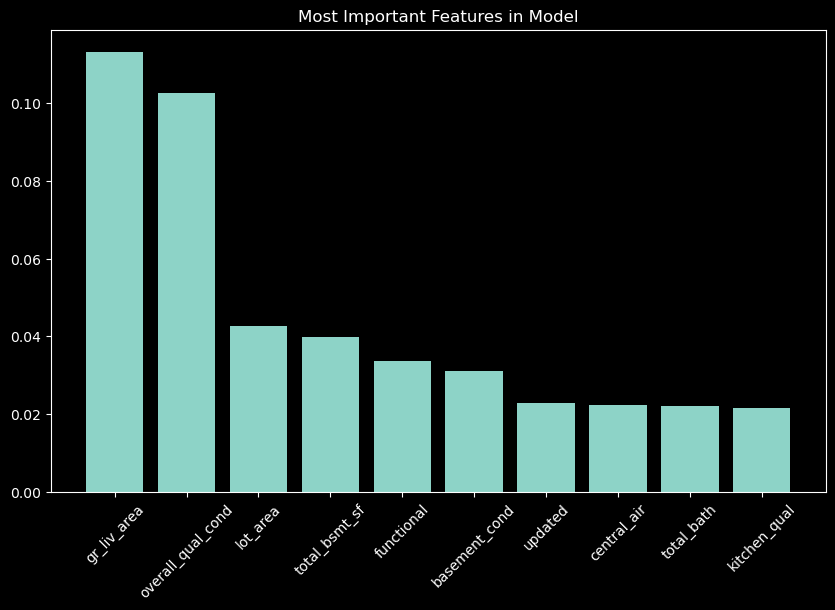

In [64]:
plot_important_features(mlr_lasso, Xs_train, n_features=10)

### Columns Lasso is Minimizing

In [65]:
squashed_columns = []
for idx, item in enumerate(mlr_lasso.coef_):
    if item == 0:
        squashed_columns.append(idx)
    
squashed_columns
Xs_train.iloc[:,squashed_columns].columns

Index(['totrms_abvgrd', 'fireplace_qu', 'alley', '2fmCon', 'Duplex', 'Twnhs',
       'HdBoard', 'VinylSd', 'Edwards', 'NAmes', 'NoRidge', 'Somerst',
       'land_house_ratio', 'has_fireplace', 'overall_qual_cond_poly',
       'mas_vnr_area_outliers', 'total_bsmt_sf_outliers',
       'gr_liv_area_outliers', 'garage_area_outliers'],
      dtype='object')

### Instantiate Ridge Model

In [66]:
mlr_ridge = Ridge()
#calculate residuals by creating predictions
mlr_ridge.fit(Xs_train,y_train)
preds = mlr_ridge.predict(Xs_train)
resid = y_train - preds

### Scores

In [67]:
get_scores(mlr_ridge, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9123306158766727
Training RMSE:  20738.556986920205
Cross Validation R^2 Score:  0.8985590872917726
Validation R^2 Score 0.9050016622681686


### Plots

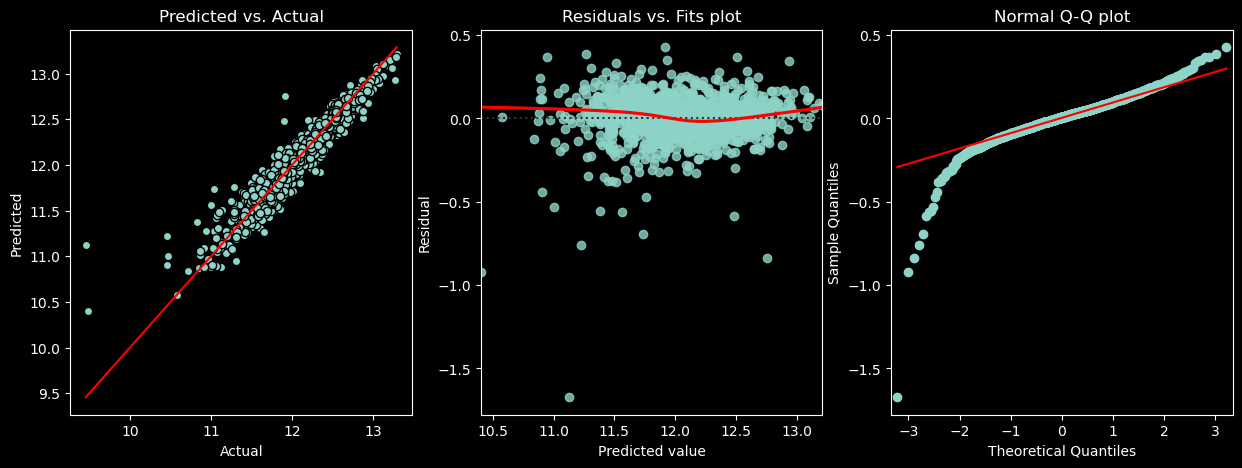

In [68]:
return_plot(preds, y_train, resid)

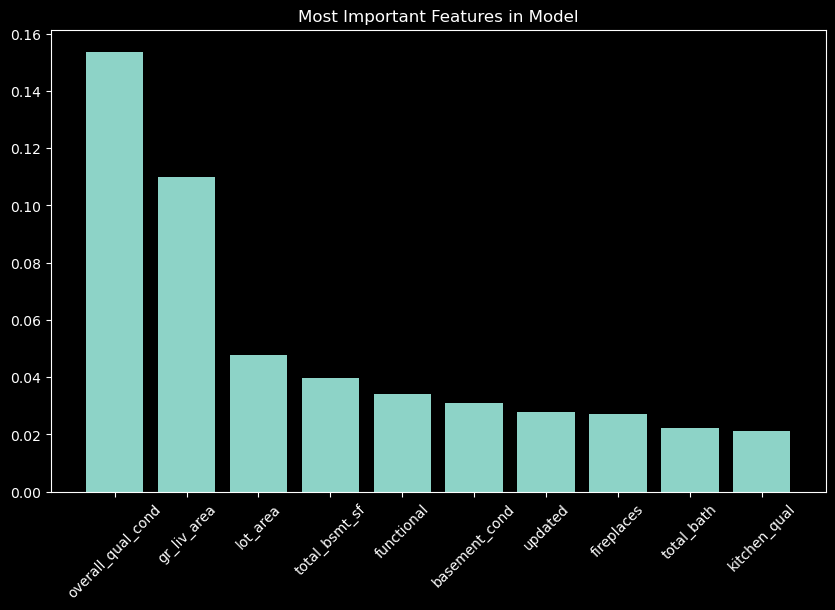

In [69]:
plot_important_features(mlr_ridge, X_train, n_features=10)

### Instantiate OLS Model

In [70]:
mlr_ols = LinearRegression()
#calculate residuals by creating predictions
mlr_ols.fit(Xs_train,y_train)
preds = mlr_ols.predict(Xs_train)
resid = y_train - preds

### Scores

In [71]:
get_scores(mlr_ols, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9112509706171646
Training RMSE:  20990.76057961049
Cross Validation R^2 Score:  0.8988196232681694
Validation R^2 Score 0.9032465476311655


### Plots

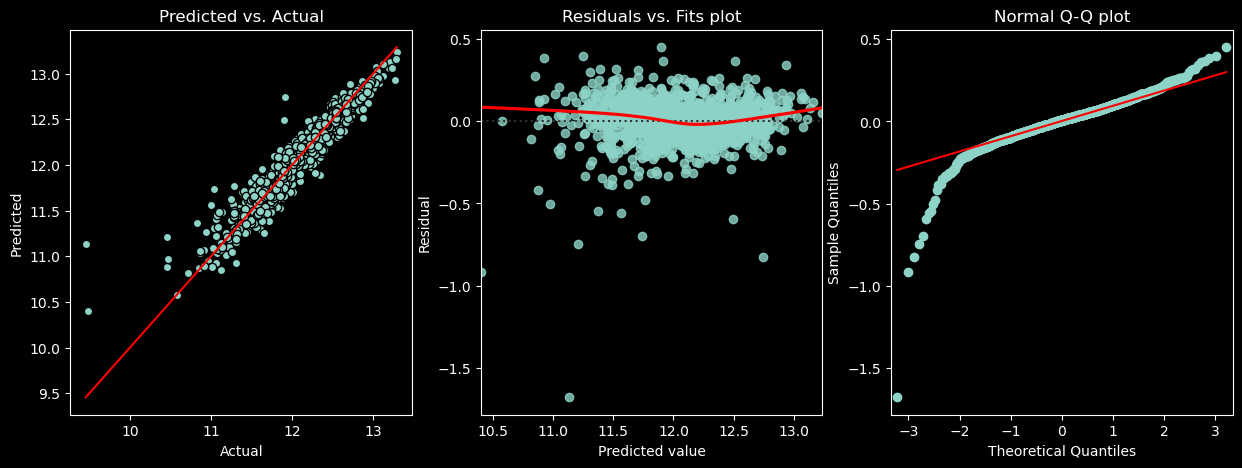

In [72]:
return_plot(preds, y_train, resid)

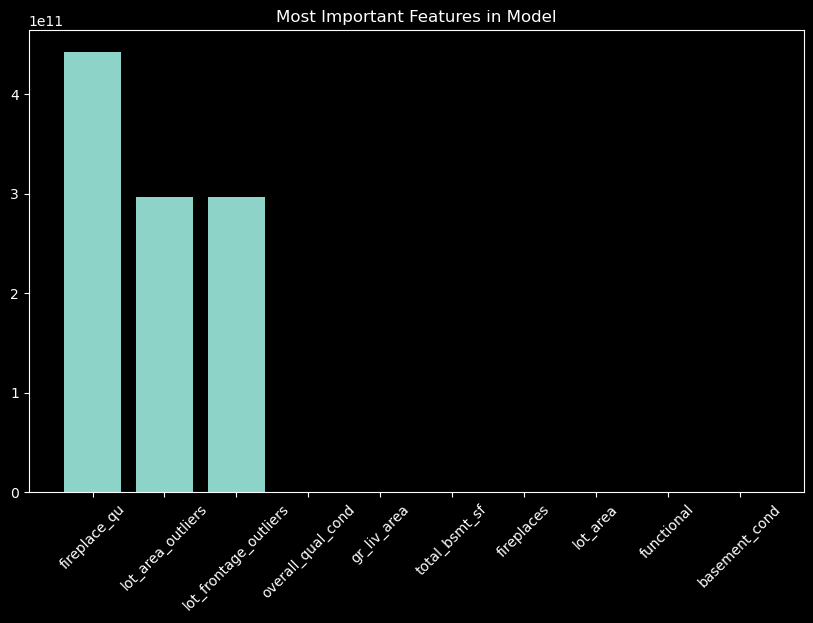

In [73]:
plot_important_features(mlr_ols, X_train, n_features=10)

# Linear Assumptions

Variance Inflation Factor

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(Xs_train.values, i) for i in range(Xs_train.shape[1])]
vif["features"] = Xs_train.columns;

vif.query('VIF_Factor > 5')

c:\Users\alexs\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF_Factor,features
3,7.174026,fireplaces
4,7.026441,garage_cars
6,7.643414,lot_area
9,12.793657,gr_liv_area
10,6.592955,garage_area
15,inf,fireplace_qu
46,85.502028,overall_qual_cond
51,12.382998,neighborhood_price_rank
55,13.846624,house_age
58,inf,has_fireplace


Statsmodels

In [75]:
X_sm = sm.add_constant(X_train)

res = sm.OLS(y_train, X_sm).fit()
preds = res.predict(sm.add_constant(X_test))
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     247.3
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:18:30   Log-Likelihood:                 1033.9
No. Observations:                1536   AIC:                            -1942.
Df Residuals:                    1473   BIC:                            -1606.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       7.1746      0.235     30.476      0.000       6.713       7.636
bedroom_abvgr              -0.0138      0.006     -2.250      0.025      -0.026      -0.002
kitchen_abvgr              -0.0763      0.031     -2.461      0.014      -0.137      -0.015
totrms_abvgrd               0.0021      0.004      0.465      0.642      -0.007       0.011
fireplaces                  0.0442      0.014      3.171      0.002       0.017       0.072
garage_cars                 0.0182      0.011      1.671      0.095      -0.003       0.040
lot_frontage                0.0244      0.017      1.405      0.160      -0.010       0.059
lot_area                    0.0972      0.018      5.394      0.000       0.062       0.133
mas_vnr_area             3.821e-05   2.32e-05      1.644      0.100   -7.37e-06    8.38e-05
total_bsmt_sf               0.0050      0.001      6.471      0.000       0.003       0.007
gr_liv_area                 0.3373      0.035      9.520      0.000       0.268       0.407
garage_area              1.878e-05   3.78e-05      0.497      0.619   -5.53e-05    9.29e-05
wood_deck_sf                0.0001    2.8e-05      3.725      0.000    4.93e-05       0.000
heating_qc                  0.0154      0.005      3.337      0.001       0.006       0.024
kitchen_qual                0.0322      0.008      4.016      0.000       0.016       0.048
functional                  0.0488      0.005      9.654      0.000       0.039       0.059
fireplace_qu               -0.0087      0.009     -1.012      0.312      -0.026       0.008
paved_drive                 0.0626      0.014      4.515      0.000       0.035       0.090
fence                       0.0033      0.009      0.366      0.714      -0.014       0.021
alley                       0.0054      0.016      0.345      0.730      -0.025       0.036
central_air                 0.0815      0.016      5.160      0.000       0.051       0.113
Feedr                       0.0149      0.019      0.781      0.435      -0.023       0.052
Norm                        0.0497      0.013      3.828      0.000       0.024       0.075
PosN                        0.0813      0.034      2.416      0.016       0.015       0.147
CBlock                      0.0162      0.095      0.170      0.865      -0.170       0.202
PConc                       0.0058      0.011      0.516      0.606      -0.016       0.028
Slab                        0.0637      0.035      1.832      0.067      -0.005       0.132
2fmCon                      0.0158      0.025      0.626      0.531      -0.034       0.065
Duplex                      0.0150      0.034      0.445      0.657      -0.051       0.081
Twnhs                       0.0057      0.025      0.230      0.818      -0.042       0.054
CemntBd                     0.0596      0.022  

# Submission

In [76]:
#E instantiate lasso with best alpha 

new_lasso = Lasso(alpha = 0.001)
new_lasso.fit(X,y)

ss = StandardScaler()
Xs_test = ss.fit_transform(X_test)
Xs_test = pd.DataFrame(Xs_test, columns = ss.get_feature_names_out())



price_preds = new_lasso.predict(X_test)
house_test['SalePrice'] = np.exp(price_preds)

house_test
house_test[['id', 'SalePrice']].to_csv('../datasets/submission.csv', index = False)

In [77]:
house_test[['id', 'SalePrice']]


,id,SalePrice
0,2658,116254.709550
1,2718,164363.501922
2,2414,229287.404876
3,1989,112848.485645
4,625,175142.159646
...,...,...
873,1662,180103.625873
874,1234,219711.311822
875,1373,131944.615017
876,1672,112373.470557


In [78]:
current_df = house_test[['id', 'SalePrice']]
best_df = pd.read_csv('../datasets/best_submission.csv')
best_df = best_df.join(current_df.set_index('id'), on='id', lsuffix='_best', rsuffix='_current')
best_df['diff'] = best_df['SalePrice_best'] - best_df['SalePrice_current']
best_df.sort_values('diff', ascending=False)

,id,SalePrice_best,SalePrice_current,diff
213,957,305442.1591,295774.666956,9667.492144
317,1001,243385.1996,234100.449877,9284.749723
856,352,223936.5858,215039.057682,8897.528118
387,1529,207420.8857,198637.004316,8783.881384
841,464,191832.0213,183285.936631,8546.084669
...,...,...,...,...
237,422,428924.9225,462802.772632,-33877.850132
120,1781,370543.1892,404457.854620,-33914.665420
115,2446,511529.0098,589690.591449,-78161.581649
170,1761,564067.5912,689797.114220,-125729.523020


In [79]:
ids = [1761, 2216, 1768]

In [80]:
house_test.query('id in @ids')

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_cond,foundation,bsmt_exposure,total_bsmt_sf,heating,heating_qc,central_air,electrical,gr_liv_area,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_finish,garage_cars,garage_area,paved_drive,wood_deck_sf,pool_area,fence,misc_val,mo_sold,sale_type,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,Greens,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,2fmCon,Duplex,Twnhs,TwnhsE,AsphShn,BrkComm,BrkFace,CemntBd,HdBoard,MetalSd,Plywood,Stucco,VinylSd,Wd Sdng,WdShing,CBlock,PConc,Slab,Stone,Wood,Tar&Grv,WdShake,WdShngl,NoSewr,Feedr.1,Norm.1,PosA.1,PosN.1,RRAe.1,RRAn.1,RRNe.1,RRNn.1,overall_qual_cond,basement_cond,2nd_story,total_bath,total_porch_sf,neighborhood_price_rank,updated,garage_age,garage_qual_cond,house_age,land_house_ratio,has_pool,has_fireplace,meltdown,lot_frontage_outliers,lot_area_outliers,mas_vnr_area_outliers,total_bsmt_sf_outliers,gr_liv_area_outliers,garage_area_outliers,gr_liv_area_poly,overall_qual_cond_poly,SalePrice
170,1761,528320050,60,RL,5.075174,9.656499,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,5,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,2,PConc,NaN,48.948953,GasA,4,1,SBrkr,8.406485,4,1,4,10,3,2,1,Attchd,Fin,3,813,1,171,555,1,0,7,WD,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.5,3.0,1,4.5,78,2,0,11.0,2.0,3.316625,3.490393,1,1,0,1,1,1,1,1,1,20034576,42.25,689797.114220
463,1768,528351010,60,RL,4.644391,9.977435,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,6,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,2,PConc,3.0,49.436828,GasA,4,1,SBrkr,8.370084,4,1,4,10,3,2,1,Attchd,Fin,3,832,1,382,0,0,0,1,WD,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,7.0,3.0,1,4.0,50,2,1,13.0,2.0,3.605551,4.989574,0,1,0,0,0,0,0,0,0,18627856,49.00,762795.327449


<AxesSubplot:xlabel='SalePrice_best', ylabel='id'>

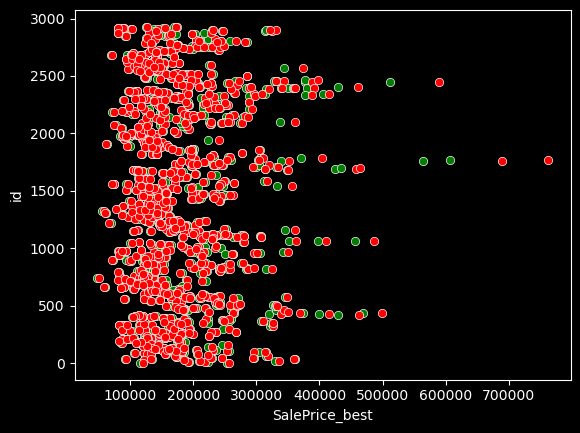

In [81]:
sns.scatterplot(best_df, x = 'SalePrice_best', y = 'id', color = 'green')
sns.scatterplot(best_df, x = 'SalePrice_current', y = 'id', color = 'red')
